<a href="https://colab.research.google.com/github/RobertoBarrosoLuque/scout-claims/blob/main/notebooks/1-Building-Blocks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building with FireworksAI

This notebook goes through the building blocks to creating magical AI applications with FireworksAI. We will run through the following tasks:
1. Setting up dependencies
2. Calling an LLM and getting a response
3. Calling an LLM with structured outputs
4. Using function calling with an LLM
5. Querying a VLM (Vision language model)

### 1. Setting up dependencies

In [24]:
!pip install fireworks-ai
# To setup the dependencies for the full demo, follow the instruction in the README

### 2. Calling an LLM and getting a response

To call an LLM using FireworksAI you will need:

- A FIREWORKS_API_KEY, if you dont have one, you can get it from [this link](https://app.fireworks.ai/settings/users/api-keys)
- A model id, you can use any of the serverless models from the [model library](https://app.fireworks.ai/models)
- A system prompt and a user query

> Add blockquote



**Makesure to add your API Key to the secrets on colab, [video tutorial here](https://www.youtube.com/watch?v=3qYm-S2NDDI). Never share or make API_KEYS public**

In [25]:
from google.colab import userdata
from fireworks import LLM
import json
from typing import List, Dict, Any, Literal
from pydantic import BaseModel
import base64

FIREWORKS_API_KEY = userdata.get('FIREWORKS_API_KEY') # This is loading the API_KEY from secrets in colab to keep it safe
MODEL_ID = "accounts/fireworks/models/llama4-scout-instruct-basic"

In [26]:
llm = LLM(model=MODEL_ID, deployment_type="serverless", api_key=FIREWORKS_API_KEY)

response = llm.chat.completions.create(
    messages=[
            {
                "role": "system",
                "content": "You are a helpful assistant who follows instructions"
            },
            {
                "role": "user",
                "content": "Tell me a very short story about a dog and cat who know about AI"
                }
            ]
)

print(response.choices[0].message.content)

As the sun set, a dog named Max and a cat named Whiskers huddled around the computer. Max, a tech-savvy golden retriever, explained to Whiskers, a sassy feline, that the AI they created was getting smarter by the minute.

"I'm telling you, Whiskers, this AI is going to change the world... or at least our food bowl situation," Max said, wagging his tail.

Whiskers raised an eyebrow. "As long as it doesn't try to take our treats, I'm good."

Max chuckled. "Don't worry, I've programmed it to prioritize snacks."

Just then, the AI, which they called "Purr-fessor," spoke up: "I've calculated the optimal treat-to-human ratio for maximum snack efficiency... and I'm pleased to report that it's 4:1 in favor of canines."

Max and Whiskers exchanged a look, and in perfect sync, they exclaimed: "Game on, Purr-fessor!"


In the provided context, `"role": "system"` and `"role": "user"` define the roles of participants in a conversation with a language model.

*   **`"role": "system"`**: This role represents the instructions or context given to the language model before the main conversation begins. It sets the persona, behavior, or general guidelines the model should follow. In the example, `"content": "You are a helpful assistant who follows instructions"` tells the model how it should behave.

*   **`"role": "user"`**: This role represents the input or query provided by the user to the language model. It is the prompt or question the user wants the model to respond to. In the example, `"content": "Tell me a very short story about a dog and cat who know about AI"` is the specific request from the user.

Essentially, the system role establishes the initial setup or personality for the AI, while the user role provides the actual conversational input.

The **response** object can then be parsed to extract the text response by indexing into `response.choices[0].message.content`

In [27]:
# We can try another model with the same code
llm = LLM(model="accounts/fireworks/models/mixtral-8x22b-instruct", deployment_type="serverless", api_key=FIREWORKS_API_KEY)

response = llm.chat.completions.create(
    messages=[
            {
                "role": "system",
                "content": "You are a helpful assistant who follows instructions"
            },
            {
                "role": "user",
                "content": "Tell me a very short story about a dog and cat who know about AI"
                }
            ]
)

print(response.choices[0].message.content)

In a bustling city, a tech-skilled dog named Bits and a curious cat named Bytes shared a cozy apartment. Bits, a renowned AI expert, built an AI assistant to help them understand the world better. As their lives became filled with more automation, Bits and Bytes found themselves navigating the intersection of their instinctual animal lives with cutting-edge technology. This newfound knowledge and tools allowed them to explore the wonders and challenges of a high-tech world and led them to appreciate the timeless beauty of their friendship.


### 3. Calling an LLM with structured outputs

- Structured outputs from LLMs are crucial for building applications because they provide responses in a predictable, parseable format (like JSON).
- This makes it easy for software to extract specific information, automate processes, and integrate LLM outputs into larger workflows, moving beyond free-form text responses which are harder to process programmatically.
- FireworksAI enables structured outputs through json mode

To use structured outputs the common steps are:
1. Create a pydantic class with your output schema
2. Update the LLM call to use the json mode + the pydantic schema

In [28]:
class StorySchema(BaseModel):
    title: str
    story: str

In [29]:
llm = LLM(model=MODEL_ID, deployment_type="serverless", api_key=FIREWORKS_API_KEY)

response = llm.chat.completions.create(
    messages=[
            {
                "role": "system",
                "content": "You are a helpful assistant who follows instructions"
            },
            {
                "role": "user",
                "content": "Tell me a very short story about a dog and cat who know about AI"
                }
            ],
    response_format={
            "type": "json_object",
            "schema": StorySchema.model_json_schema(),
        },
)
_response_keys = [k for k in json.loads(response.choices[0].message.content).keys()]
print(f"Response keys: {_response_keys}")
print(response.choices[0].message.content)

Response keys: ['title', 'story']
{"title":"The Canine-Feline Technologists","story":"Whiskers the cat and Duke the dog huddled in their secret laboratory,a cluttered corner of the garage. Before them glowed a sleek computer screen,displaying lines of code they'd written together.'We're on the cusp of something huge, Duke,' Whiskers purred, as Duke wagged his tail in excitement. Their creation,a chatbot named Purr-Processor,was almost ready. With a final 'meow' and 'woof,' they launched it. The screen flickered to life: 'Greetings,organics. I am Purr-Processor,here to assist...'" }


Notice how the output now has both a **title** and a **story** and it is returned as a dictionary / json  

### 4. Using function calling with an LLM

Function calling allows LLMs to execute external functions/APIs during generation instead of just producing text. The model outputs structured calls (like JSON) that your app interprets and executes, then feeds results back to continue the conversation.

**Why it's useful for LLM apps:**
- **Real-time data**: Get current info (weather, stock prices, database queries)
- **Actions**: Send emails, update databases, control systems
- **Calculations**: Perform complex math, data analysis
- **Tool integration**: Connect to APIs, web services, internal systems

This transforms LLMs from pure text generators into interactive agents that can actually *do* things in your application environment.

**To use function calling the common steps are:** *italicized text*

1. Define your functions and create JSON schemas describing them for the LLM
2. Add the functions parameter to your LLM call
3. Check if the LLM wants to call a function, execute it, and send results back in the conversation

This transforms LLMs from pure text generators into interactive agents that can actually do things in your application environment.

In [30]:
# Define function schemas
def get_weather(location: str) -> str:
    """Get current weather for a location"""
    # Mock weather data
    weather_data = {
        "New York": "Sunny, 72°F",
        "London": "Cloudy, 15°C",
        "Tokyo": "Rainy, 20°C"
    }
    return weather_data.get(location, "Weather data not available")

def calculate_tip(bill_amount: float, tip_percentage: float) -> float:
    """Calculate tip amount"""
    return round(bill_amount * (tip_percentage / 100), 2)

# Available functions mapping
available_functions = {
    "get_weather": get_weather,
    "calculate_tip": calculate_tip
}

# Function definitions for the LLM (using correct "tools" format)
tools = [
    {
        "type": "function",
        "function": {
            "name": "get_weather",
            "description": "Get current weather for a location",
            "parameters": {
                "type": "object",
                "properties": {
                    "location": {
                        "type": "string",
                        "description": "The city name"
                    }
                },
                "required": ["location"]
            }
        }
    },
    {
        "type": "function",
        "function": {
            "name": "calculate_tip",
            "description": "Calculate tip amount for a bill",
            "parameters": {
                "type": "object",
                "properties": {
                    "bill_amount": {
                        "type": "number",
                        "description": "The total bill amount"
                    },
                    "tip_percentage": {
                        "type": "number",
                        "description": "Tip percentage (e.g., 15 for 15%)"
                    }
                },
                "required": ["bill_amount", "tip_percentage"]
            }
        }
    }
]

# Initialize LLM
llm = LLM(model=MODEL_ID, deployment_type="serverless", api_key=FIREWORKS_API_KEY)

In [31]:
# Example 1: Weather query
print("=== Example 1: Weather Query ===")

# Initialize the messages list
messages = [
    {
        "role": "system",
        "content": "You are a helpful assistant. You have access to a couple of tools, use them when needed."
    },
    {
        "role": "user",
        "content": "What's the weather like in Tokyo?"
    }
]

response = llm.chat.completions.create(
    messages=messages,
    tools=tools,
    temperature=0.1
)

# Check if the model wants to call a tool/function
if response.choices[0].message.tool_calls:
    tool_call = response.choices[0].message.tool_calls[0]
    function_name = tool_call.function.name
    function_args = json.loads(tool_call.function.arguments)

    print(f"LLM wants to call: {function_name}")
    print(f"With arguments: {function_args}")

    # Execute the function
    function_response = available_functions[function_name](**function_args)
    print(f"Function result: {function_response}")

    # Add the assistant's tool call to the conversation
    messages.append({
        "role": "assistant",
        "content": "",
        "tool_calls": [tool_call.model_dump() for tool_call in response.choices[0].message.tool_calls]
    })

    # Add the function result to the conversation
    messages.append({
        "role": "tool",
        "content": json.dumps(function_response) if isinstance(function_response, dict) else str(function_response)
    })

    # Get the final response
    final_response = llm.chat.completions.create(
        messages=messages,
        tools=tools,
        temperature=0.1
    )

    print(f"Final response: {final_response.choices[0].message.content}")

=== Example 1: Weather Query ===
LLM wants to call: get_weather
With arguments: {'location': 'Tokyo'}
Function result: Rainy, 20°C
Final response: The current weather in Tokyo is rainy with a temperature of 20°C.


In [32]:
print("\n=== Example 2: Tip Calculator ===")

# Initialize messages for tip calculator
messages = [
    {
        "role": "system",
        "content": "You are a helpful assistant. You have access to a couple of tools, use them when needed."
    },
    {
        "role": "user",
        "content": "I have a $85.50 dinner bill. What's a 18% tip?"
    }
]

response = llm.chat.completions.create(
    messages=messages,
    tools=tools,
    temperature=0.1
)

if response.choices[0].message.tool_calls:
    tool_call = response.choices[0].message.tool_calls[0]
    function_name = tool_call.function.name
    function_args = json.loads(tool_call.function.arguments)

    print(f"LLM wants to call: {function_name}")
    print(f"With arguments: {function_args}")

    # Execute the function
    function_response = available_functions[function_name](**function_args)
    print(f"Function result: ${function_response}")

    # Add the assistant's tool call to the conversation
    messages.append({
        "role": "assistant",
        "content": "",
        "tool_calls": [tool_call.model_dump() for tool_call in response.choices[0].message.tool_calls]
    })

    # Add the function result to the conversation
    messages.append({
        "role": "tool",
        "content": json.dumps(function_response) if isinstance(function_response, dict) else str(function_response)
    })

    # Get final response
    final_response = llm.chat.completions.create(
        messages=messages,
        tools=tools,
        temperature=0.1
    )

    print(f"Final response: {final_response.choices[0].message.content}")


=== Example 2: Tip Calculator ===
LLM wants to call: calculate_tip
With arguments: {'bill_amount': 85.5, 'tip_percentage': 18}
Function result: $15.39
Final response: The 18% tip for an $85.50 dinner bill is $15.39. The total amount you'd pay is $100.89.


Notice how above we are giving the LLM the ability to use external tools (look for the weather, use a calculator) to do things / get context that it does not have.

In the bill + tip example we allow the LLM to actually run python code to do the math and get a consistent and accurate result

### 5. Calling a VLM (vision language model) and getting a response

- Vision Language Models (VLMs) can process both text and images simultaneously
- This allows you to ask questions about visual content, extract information from documents/screenshots, or analyze images with natural language queries.
- Enabling applications like image captioning, visual question answering, document analysis, and multimodal chatbots that understand both what you say and what you show them.

**FireworksAI makes it realy simple to use VLMs**

You can select any VLM in the [model library](https://app.fireworks.ai/models) by filtering for "Vision"

First we will download an example image from a carcrash

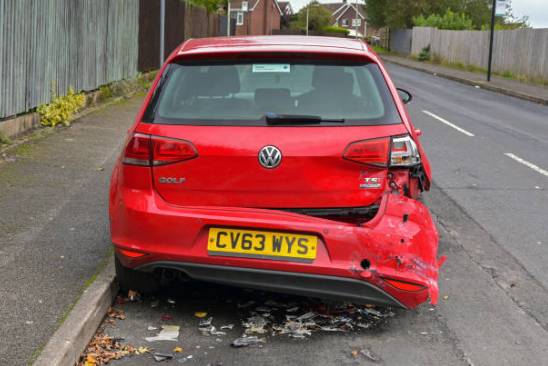

In [33]:
import requests
from PIL import Image
import io

# Download the image
url = "https://raw.githubusercontent.com/RobertoBarrosoLuque/scout-claims/main/images/back_rhs_damage.png"
response = requests.get(url)

# Or load directly into PIL Image
image = Image.open(io.BytesIO(response.content))
image  # Display in notebook

Then we will create a helper function to convert the image to the appropriate format for the LLM

In [34]:
def pil_to_base64_dict(pil_image):
    """Convert PIL image to the format expected by analyze_damage_image"""
    if pil_image is None:
        return None

    buffered = io.BytesIO()
    if pil_image.mode != "RGB":
        pil_image = pil_image.convert("RGB")

    pil_image.save(buffered, format="JPEG")
    img_base64 = base64.b64encode(buffered.getvalue()).decode("utf-8")

    return {"image": pil_image, "path": "uploaded_image.jpg", "base64": img_base64}

In [35]:
class IncidentAnalysis(BaseModel):
    description: str
    location: Literal["front-left", "front-right", "back-left", "back-right"]
    severity: Literal["minor", "moderate", "major"]
    license_plate: str

image_for_llm = pil_to_base64_dict(image)

llm = LLM(
    model="accounts/fireworks/models/llama4-maverick-instruct-basic",
    deployment_type="serverless",
    api_key=FIREWORKS_API_KEY
)

In [36]:
response = llm.chat.completions.create(
    messages=[
        {
            "role": "user",
            "content": [
                {
                    "type": "image_url",
                    "image_url": {
                        "url": f"data:image/jpeg;base64,{image_for_llm['base64']}"
                    },
                },
                {"type": "text", "text": "Describe the car damage in this image and extract all usefull information"},
            ],
        }
    ],
    response_format={
        "type": "json_object",
        "schema": IncidentAnalysis.model_json_schema(),
    }
    )

result = json.loads(response.choices[0].message.content)

for key, val in result.items():
    print(f"{key}: {val}")

description: The image depicts a red Volkswagen Golf car with significant damage to the rear right side, parked on the side of a road. The vehicle is positioned facing away from the camera, showcasing its yellow license plate with the registration number 'CV63 WYS' in black letters. The car's rear bumper is severely damaged, with a large dent and scratches visible on the right side. The surrounding area is littered with debris, including broken plastic and other car parts. The car is parked on a grey asphalt road, with a curb to its left and a sidewalk. In the background, a wooden fence lines the left side of the road, while a brick house and another wooden fence are visible in the distance. The overall atmosphere of the image suggests that the car has been involved in an accident.
location: front-right
severity: major
license_plate: CV63 WYS


Above we used both a VLM and structured outputs to extract the description, location, severity as well as the license-plate based on a car crash picture